# Rossmann Store Sales

## Goal: EDA 

We start with the Exploratory Data Analysis of the main metrics revealing present trends and patterns in the data, giving a solid foundation for the further causal analysis. 

In addition to using Prophet, I explore the use one of the most robust and sophisticated algorithm Extreme Gradient Boosting for regression.

### Import Necessary Modules

In [80]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

# machine learning: XGB
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper

### Read Data

In [101]:
# importing train data to learn
train = pd.read_csv('/mnt/disks/disk-1/data/rossmann/train.csv', 
                    parse_dates = True, low_memory = False, index_col = 'Date')

# additional store data
store = pd.read_csv("/mnt/disks/disk-1/data/rossmann/store.csv", 
                    low_memory = False)
# time series as indexes
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

### Exploratory Data Analysis

<li> this section will handle missing values and create new features for further analysis.

In [102]:
# first glance at the train set: head and tail
print("In total: ", train.shape)
train.head(5).append(train.tail(5))

In total:  (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1


#### Data Dictionary

- Open: an indicator for whether the store was open: 0 = closed, 1 = open.
- Promo: indicates whether a store is running a promo on that day.
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. 
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.

<li> Since we are dealing with time series data so it's a good idea to break up date into its individual components.
<li> Also, we can define a new feature, "sale per cusomer"

In [103]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

### [What is ECDF](https://en.wikipedia.org/wiki/Empirical_distribution_function)
<li>  ECDF value at any specified value of the measured variable is the fraction of observations of the measured variable that are less than or equal to the specified value.

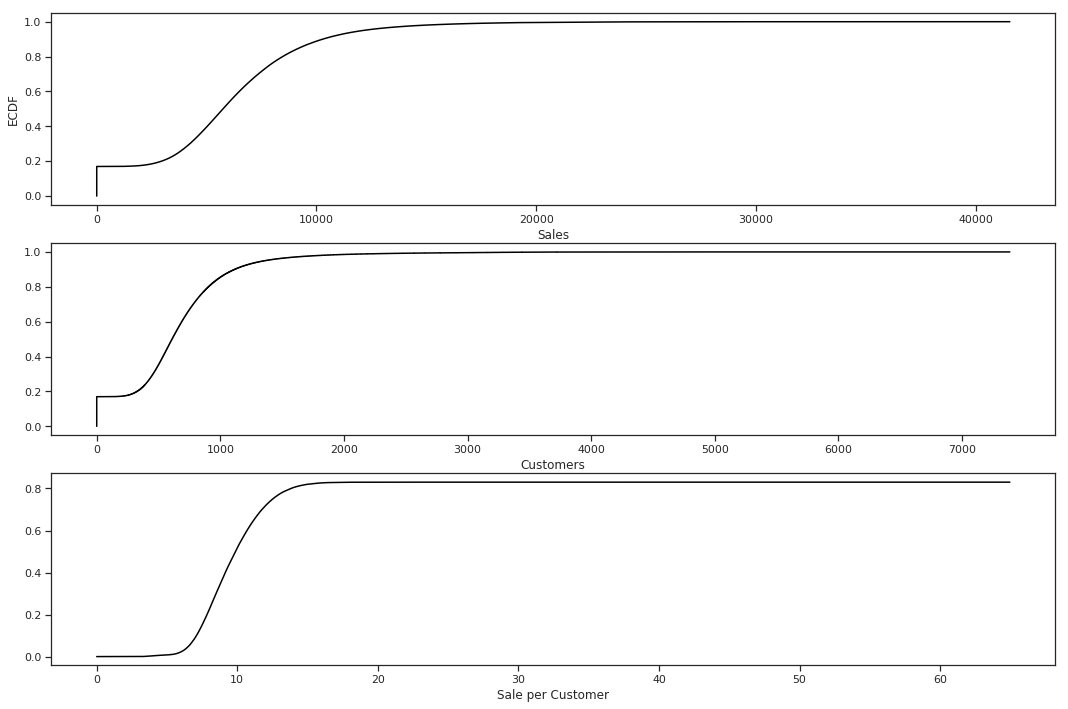

In [104]:
sns.set_context('poster')
sns.set(style = "ticks")# to format into seaborn 
c = 'black' # basic color for plots
plt.figure(figsize = (18, 12))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

<li> About 20% of data has zero amount of sales/customers that we need to deal with and almost 80% of time daily amount of sales was less than 1000. So what about zero sales, is it only due to the fact that the store is closed?

### Missing values 
#### Closed stores with zero sales

In [105]:
# closed stores
print('Number of closed stores: {0}'.format(len(train[(train.Open == 0) & (train.Sales == 0)])))

Number of closed stores: 172817


#### Open stores with zero sales

In [106]:
# opened stores with zero sales
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print('Number of closed stores: {0}'.format(zero_sales.shape))
zero_sales.head(5)

Number of closed stores: (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


In [107]:
print("Closed stores and days with Zero sales won't be counted in the forecast.")

train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

Closed stores and days with Zero sales won't be counted in the forecast.
In total:  (844338, 13)


#### Store Data Dictionary
- Store: a unique Id for each store
- StoreType: differentiates between 4 different store models: a, b, c, d
- Assortment: describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance: distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
- Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
- PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [108]:
# missing values?
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

### Data Wrangling
#### CompetitionDistance

In [109]:
# missing values in CompetitionDistance
len(store[pd.isnull(store['CompetitionDistance'])])

3

In [110]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

#### Promo2SinceWeek

In [111]:
# no promo = no information about the promo?
a11 = store[pd.isnull(store.Promo2SinceWeek)]
a11[a11.Promo2 != 0].shape

(0, 10)

if there's no `Promo2` then there's no information about it and can be replaced by zero. 
The same is true for `CompetitionOpenSinceMonth` and `CompetitionOpenSinceYear`.

In [112]:
# replace NA's by 0
store.fillna(0, inplace = True)

In [114]:
# Join train and store by specifying inner join to ensure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)

In total:  (844338, 22)


### Store types

Now let's examine different `StoreType` and distribution of `Sales` across them.  

In [116]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


`StoreType` B has the highest average of Sales, albeit very little data compared to other stores. <br>
Let's print an the sum of `Sales` and `Customers` to see which `StoreType` is the most popular.

In [125]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum().sort_values(by='Sales', ascending=False)

,Customers,Sales
StoreType,,
a,363541431,3165334859
d,156904995,1765392943
c,92129705,783221426
b,31465616,159231395


Clearly A, and D stores lead in terms of `Sales` and `Customers`. <br>

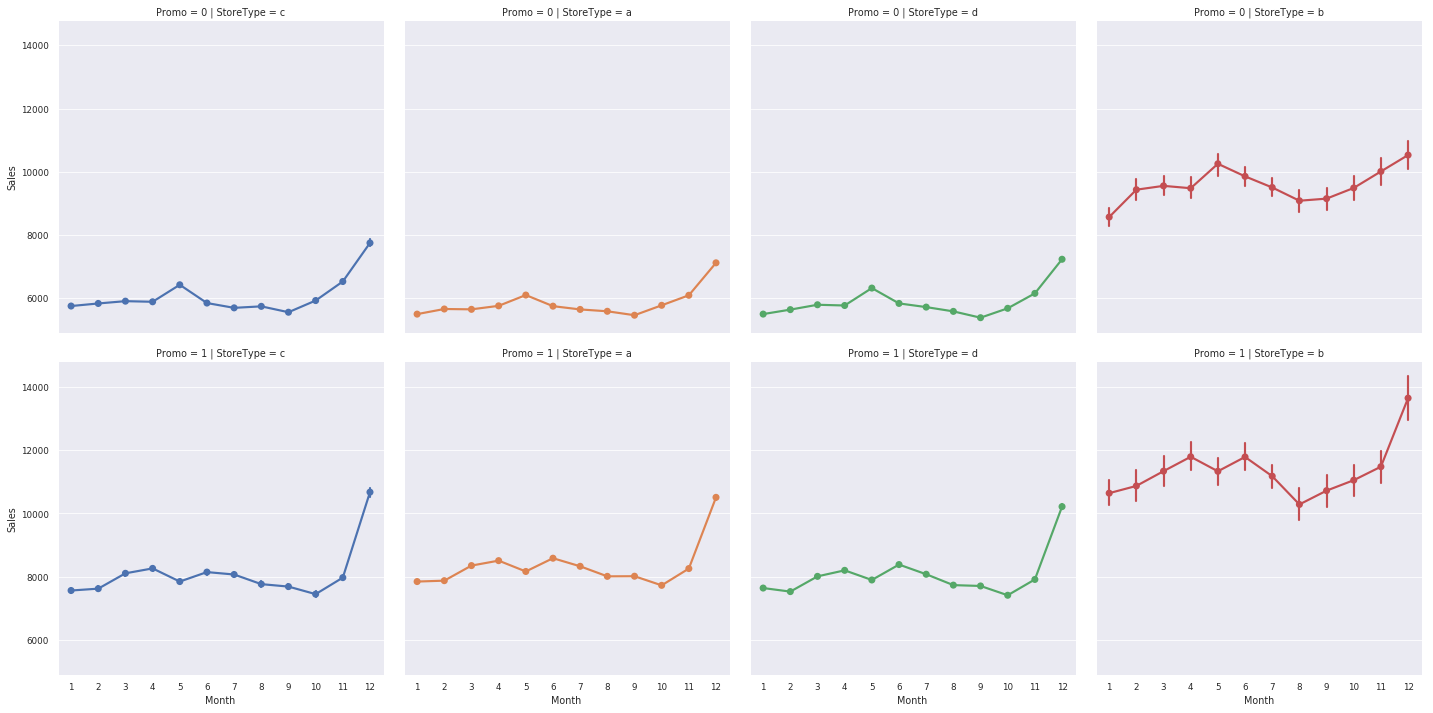

In [134]:
# sales trends
sns.set_style('darkgrid')
sns.set_context('paper')
_=sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'deep',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

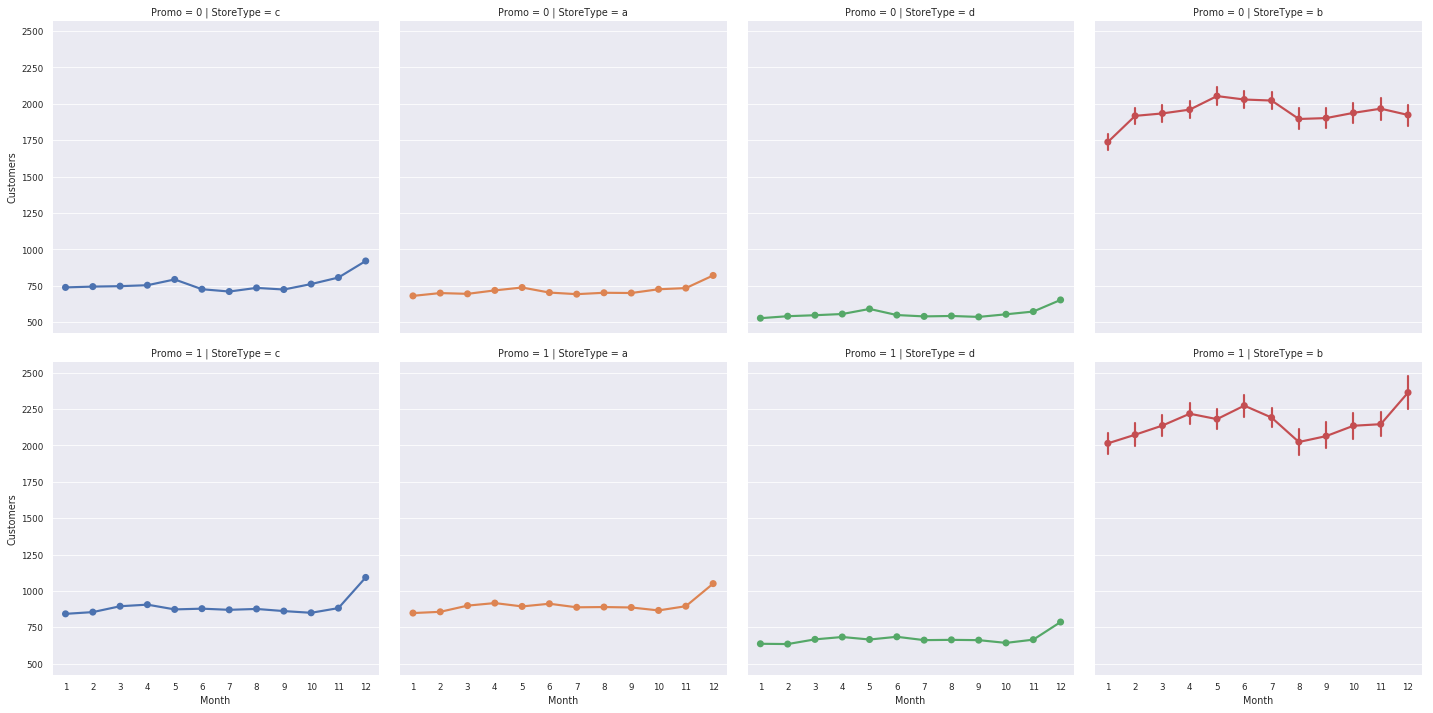

In [135]:
# customer trends
sns.set_style('darkgrid')
sns.set_context('paper')
_=sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'deep',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

All store types follow the same trend but at different scales depending on the presence of the (first) promotion `Promo` and `StoreType` itself (case for B).

_At this point, increasing Sales towards Christmas holidays is evident, but we'll talk about seasonaliy and trends later in the Time Series Analysis section._

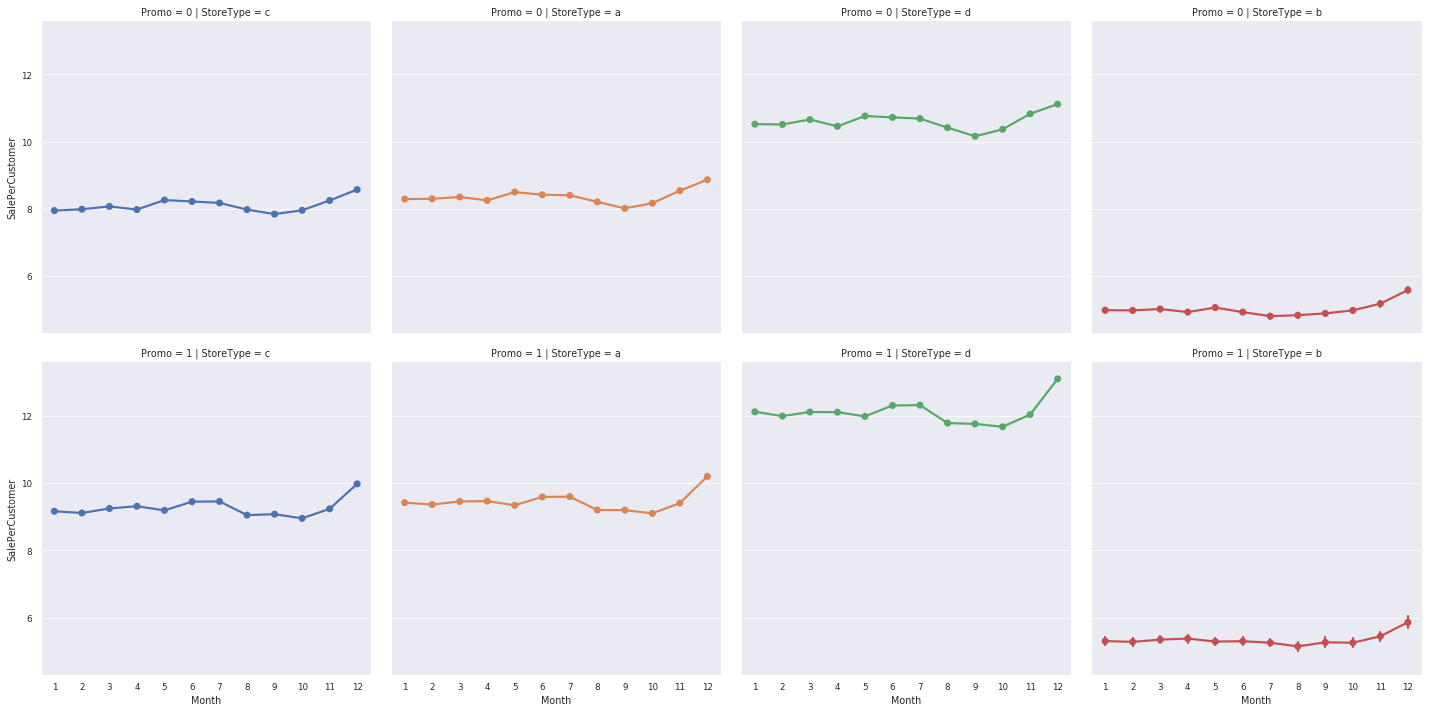

In [136]:
# sale per customer trends
sns.set_style('darkgrid')
sns.set_context('paper')
_=sns.factorplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'deep',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

Even though the plots above showed `StoreType` B as the most popular, though in reality that is not true. The highest `SalePerCustomer` amount is observed at the `StoreType` D, ~ 12€ with `Promo` and ~ 10€ without a promo, and for `StoreType` A and C it is about 9€. <br>
Based on low `SalePerCustomer` amount for `StoreType` B, we can attempt to describe the Cart: there are a lot of people who shop essentially for **small** things (or in a little quantity).

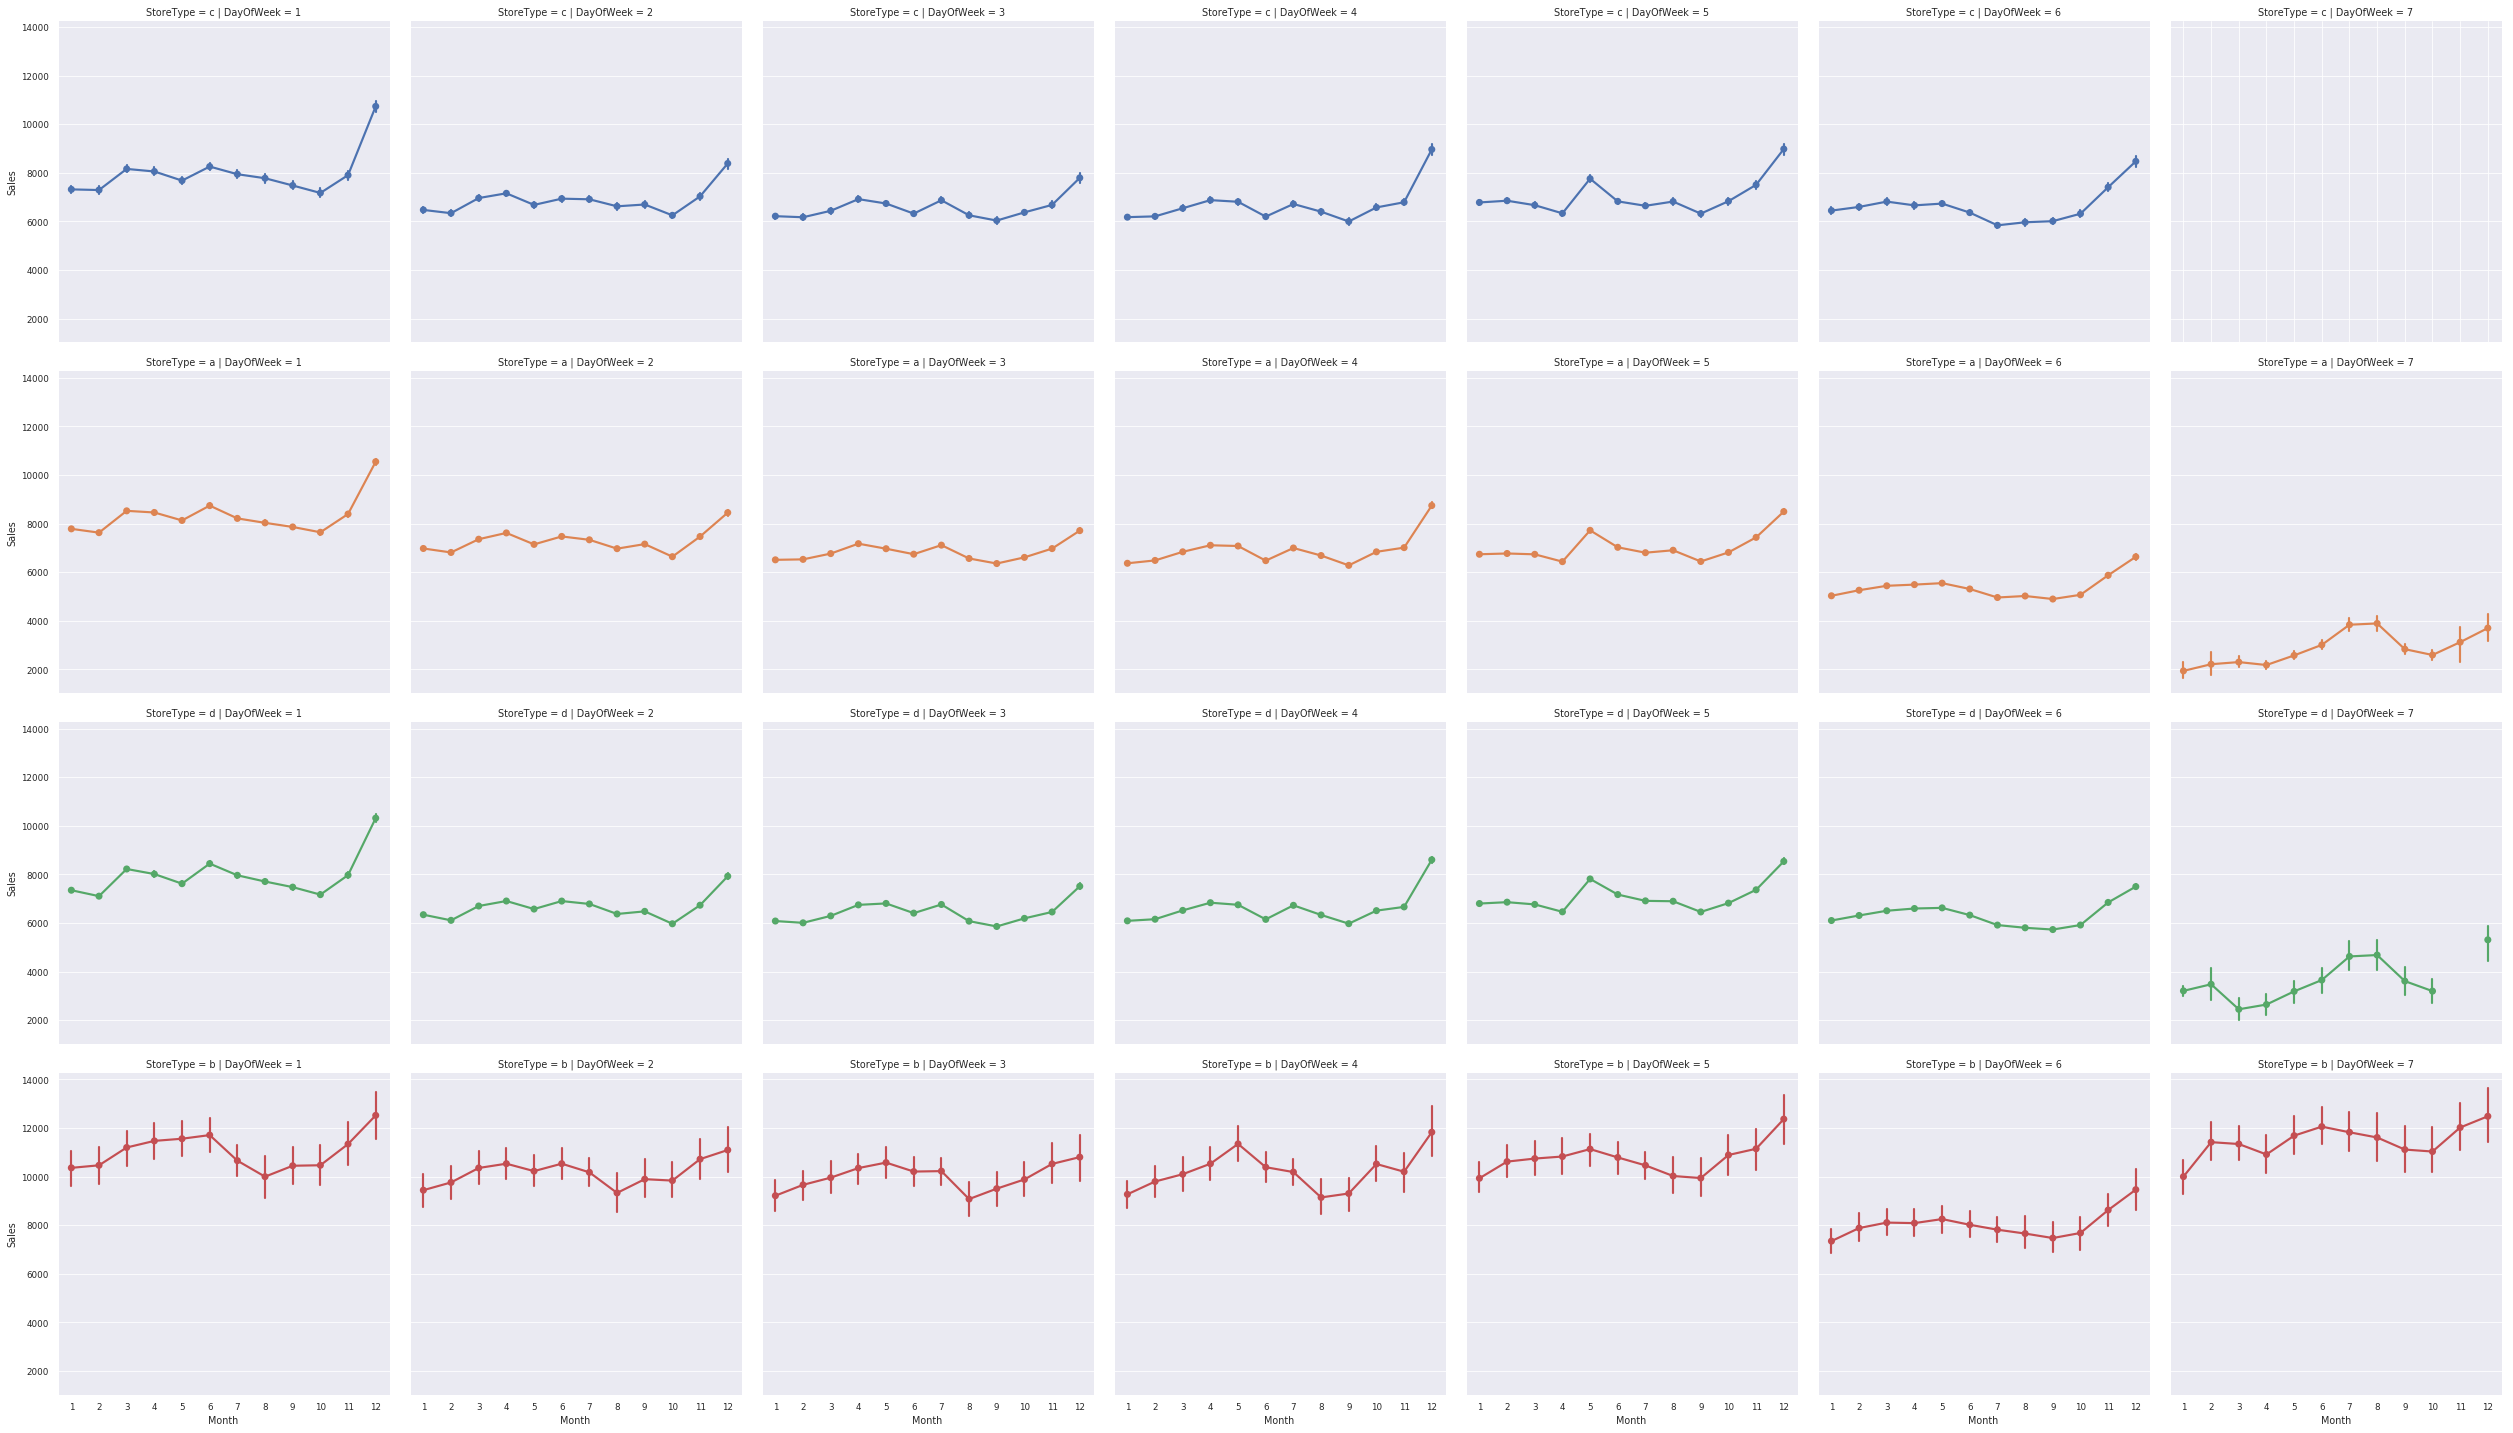

In [137]:
# customers
sns.set_style('darkgrid')
sns.set_context('paper')
_=sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'deep',
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               color = c) 

We see that stores of `StoreType` C are closed on Sundays, whereas others are open. Interestingly enough, stores of `StoreType` D are closed on Sundays only from October to December.

By the way which stores which are open on Sundays?

In [138]:
# stores which are opened on Sundays
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099])

In [140]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean().sort_values(by='Sales', ascending=False)

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
a,6925.697986,795.422370,12918.492198,7115.514452
d,6822.300064,606.353935,10421.916846,9028.526526


`StoreType` B, has the longest running period of promotion.

### Correlational Analysis

We are finished with adding new variables to the data, so now we can check the overall correlations by plotting the `seaborn` heatmap:

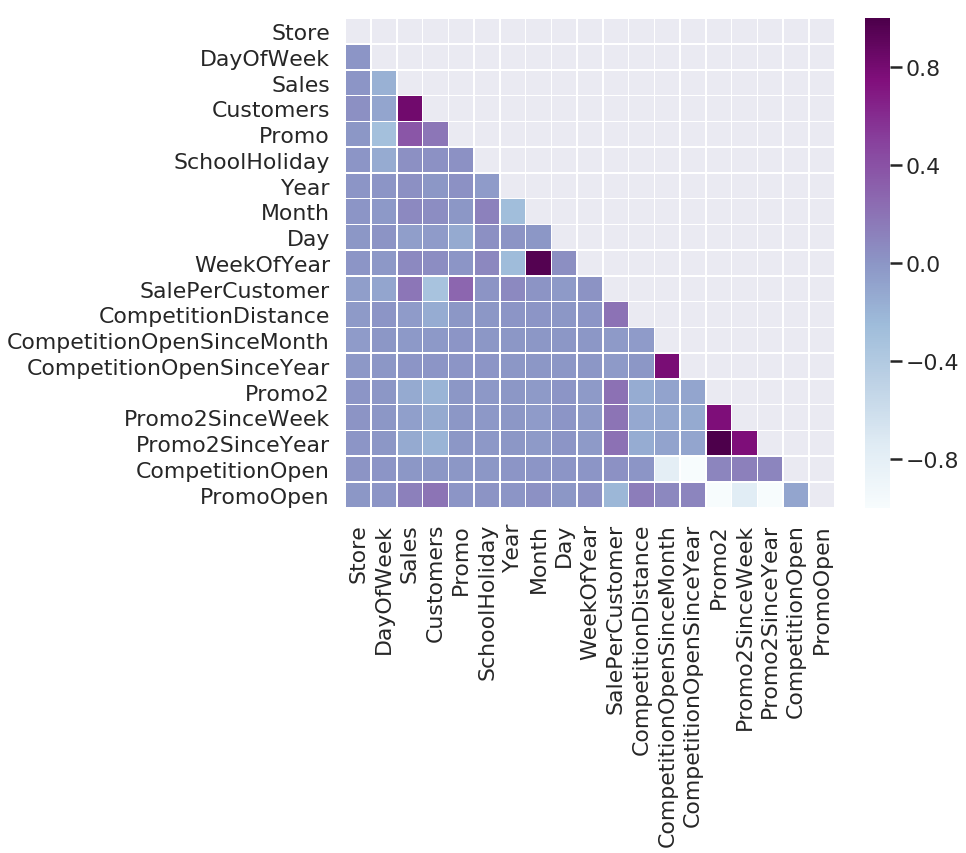

In [144]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.set_context('poster')
sns.set_style('darkgrid')
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

We can identify a positive correlation between the amount of Sales and Customers of a store.<br>
We can also observe a positive correlation between the fact that the store had a running promotion (`Promo` equal to 1) and amount of `Customers`.  <br>
Interestingly enough though, as soon as a store has consecutive promotions (`Promo2` equal to 1) the number of `Customers` and `Sales` seems to stay steady or even decrease, which is described by the pale negative correlation on the heatmap. <br>
The same negative correlation is observed between the presence of the promotion in the store and the day of a week.

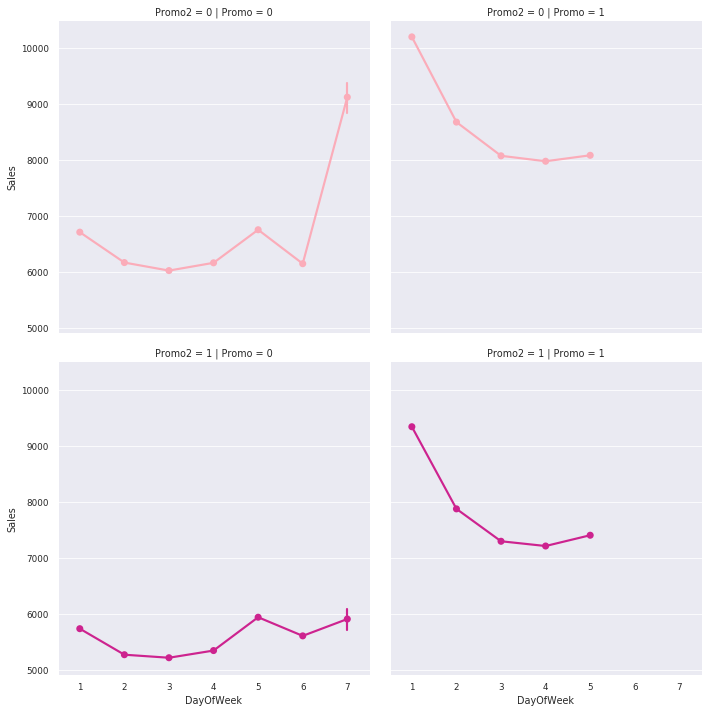

In [148]:
# sale per customer trends
sns.set_context('paper')
sns.set_style('darkgrid')
_=sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu') 

Few things to be noted from above <br>
In case of no active promotion, both `Promo` and `Promo2` equal to 0, `Sales` tend to peak on Sunday. Though we should note that `StoreType` C doesn't work on Sundays.<br>
On the contrary, stores that run the promotion tend to make most of the `Sales` on Monday. This fact could be a good indicator for Rossmann marketing campaigns. The same trend follow the stores which have both promotion at the same time (`Promo` and `Promo2` are equal to 1). <br>
`Promo2` alone doesn't seem to be correlated to any significant change in the `Sales` amount. <br>

## Summary of EDA

The `StoreType` is A is most crowded with highest sales.<br>
`StoreType` D with highest "**Sale per Customer**"  indicates a strong Buyer Cart. An interesting thing to do will be to map these stores on the map to check whether they are urban or rural locations.<br>
Low `SalePerCustomer` amount for `StoreType` B alludes to the possibility that people are essentially shopping for sundry items. An interesting thing to do will be to map these stores on the map to check whether they are urban or rural locations and compare it against locations from point 2. <br>
Customers tends to buy more on Mondays when there's a single promotion running (`Promo`) and on Sundays when there is no promotion at all (both `Promo` and `Promo1` are equal to 0).<br> 

## Time-Series Analysis by Store Type

What makes a time series different from a regular regression problem? 

- It is time dependent. The basic assumption of a linear regression that the observations are independent doesn’t hold in this case.


- Along with an increasing or decreasing trend, most time series have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, for Christmas holidays, which we will see in this dataset.

<div class = "alert alert-block alert-info"> We build a time series analysis on store types instead of individual stores. The main advantage of this approach is its simplicity of presentation and overall account for different trends and seasonaltities in the dataset. </div>

In this section, we will analyse time series data: its trends, sesonalities and autocorrelation. Usually at the end of the analysis, we are able to develop a seasonal ARIMA (Autoregression Integrated Moving Average) model but it won't be our main focus today. Instead, we try to understand the data, and only later come up with the forecasts using Prophet methodology.

### Seasonality

We take four stores from store types to represent their group:
- Store number 2 for `StoreType` A
- Store number 85 for `StoreType` B, 
- Store number 1 for `StoreType` C 
- Store number 13 for `StoreType` D. 

It also makes sense to downsample the data from days to weeks using the `resample` method to see the present trends more clearly.

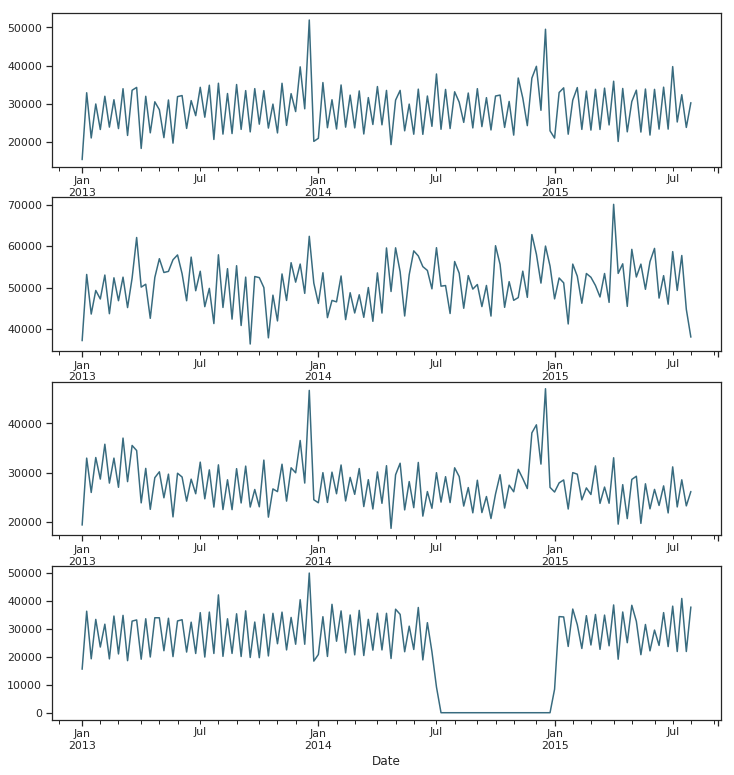

In [28]:
# preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

Retail sales for `StoreType` A and C tend to peak for the Christmas season and then decline after the holidays. We might have seen the same trend for `StoreType` D (at the bottom) but there is no information from July 2014 to January 2015 about these stores as they were closed.

### Yearly trend

The next thing to check the presence of a trend in series.

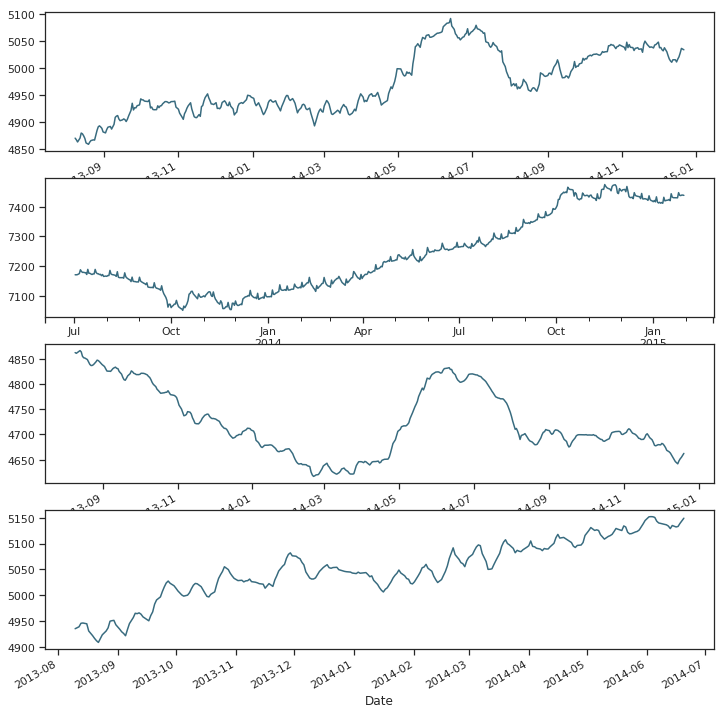

In [29]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color = c, ax = ax4)

Overall sales seems to increase, however not for the `StoreType` C (a third from the top). Eventhough the `StoreType` A is the most selling store type in the dataset, it seems that it cab follow the same decresing trajectory as `StoreType` C did.

### Autocorrelaion

The next step in ourtime series analysis is to review Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots. 

ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points).

PACF, on the other hand, measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4. 

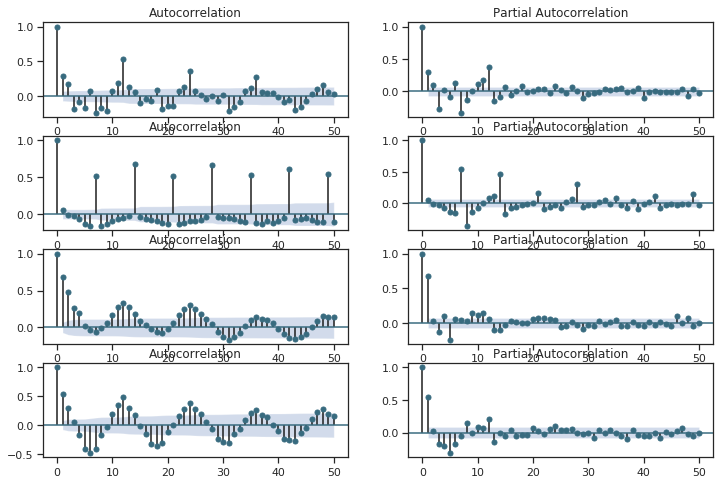

In [30]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)

plt.show()

We can read these plots horizontally. Each horizontal pair is for one 'StoreType', from A to D. In general, those plots are showing the correlation of the series with itself, lagged by x time units correlation of the series with itself, lagged by x time units.

There is at two things common for each pair of plots: non randomnes of the time series and high lag-1 (which will probably need a higher order of differencing d/D).

- Type A and type B:
Both types show seasonalities at certain lags. For type A, it is each 12th observation with positives spikes at the 12 (s) and 24(2s) lags and so on. For type B it's a weekly trend with positives spikes at the 7(s), 14(2s), 21(3s) and 28(4s) lags. 


- Type C and type D:
Plots of these two types are more complex. It seems like each observation is coorrelated to its adjacent observations. 

## Time Series Analysis and Forecasting with Prophet
#### Forecasting for the next 6 weeks for the first store

The Core Data Science team at Facebook recently published a new procedure for forecasting time series data called [Prophet](https://research.fb.com/prophet-forecasting-at-scale/). It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It enables performing [automated forecasting which are already implemented in R](https://www.rdocumentation.org/packages/forecast/versions/7.3/topics/auto.arima) at scale in Python 3.

In [32]:
# importing data
df = pd.read_csv("/mnt/disks/disk-1/data/rossmann/train.csv",  
                    low_memory = False)

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [33]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


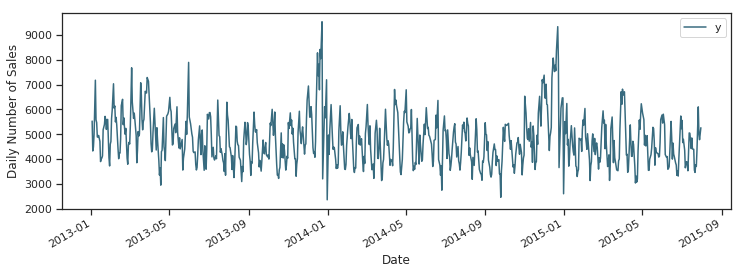

In [34]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

### Modeling Holidays

Prophet also allows to [model for holidays](https://facebookincubator.github.io/prophet/docs/holiday_effects.html), and that's what we do here.

The StateHoliday variable in the dataset indicates a state holiday, at which all stores are normally closed. There are also school holidays in the dataset at which ceratin stores are also closing their doors.

In [35]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [36]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


First week to forecast.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [37]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4092.315126,2485.275131,5739.742100
817,2015-09-06,4087.136609,2432.816496,5666.798724
818,2015-09-07,4161.901669,2544.192949,5809.401189
819,2015-09-08,3664.283500,2159.005827,5271.867807
820,2015-09-09,3551.082173,1995.869137,5184.498270
821,2015-09-10,3462.584725,1752.776858,5062.628949
822,2015-09-11,3717.252800,2167.650575,5389.354998


The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [38]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

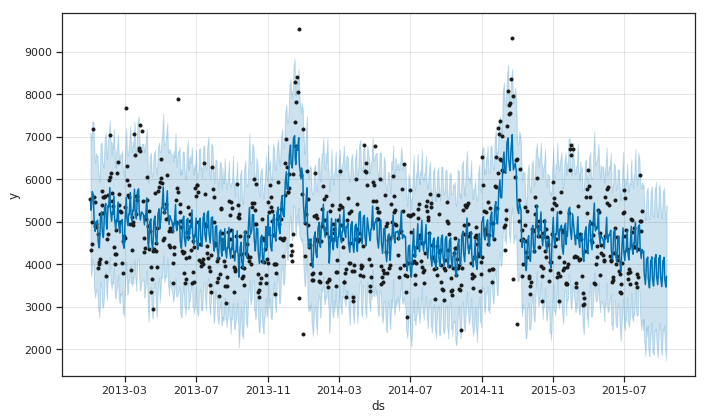

In [39]:
# visualizing predicions
my_model.plot(forecast);

As we see Prophet catches the trends and most of the time gets future values right.

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series plus manyally included holidayes contribute to the overall forecasted values:

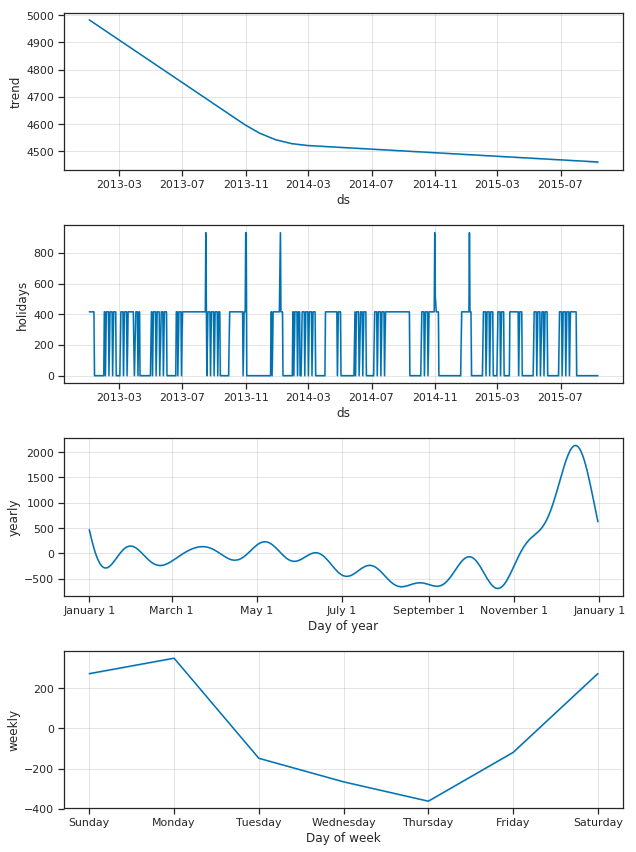

In [40]:
my_model.plot_components(forecast);

The first plot shows that the monthly sales of store number 1 has been linearly decreasing  over time and the second shows the holiays gaps included in the model. The third plot highlights the fact that the weekly volume of last week sales peaks towards the Monday of the next week, while the forth plot shows that the most buzy season occurs during the Christmas holidays.

### Conclusion of Time Series forecasting

During this part we discussed time series analysis with `.seasonal_decompose()`, `ACF` and `PCF` plots and fited forecasting model using a new procedure by Facebook `Prophet`.

We can now present main advantages and drawbacks of time series forecasting:

__Advantages__
- Powerfull tool for the time series forecasting as it accounts for time dependencies, seasonalities and holidays (Prophet: manualy).
- Easily implemented with R `auto.arima()` from `forecast` package, which runs a complex grid search and sophisticated algorythm behind the scene.

__Drawbacks__
- Doesn't catch interactions between external features, which could improve the forecasting power of a model. In our case, these variables are `Promo` and `CompetitionOpen`. 
- Eventhough Prophet offers an automated solution for ARIMA, this methodology is under development and not completely stable.
- Fitting seasonal ARIMA model needs 4 to 5 whole seasons in the dataset, which can be the the biggest drawback for new companies.
- Seasonal ARIMA in Python has 7 hyperparameters which can be tuned only manually affecting significantly the speed of the forecasting process.

<br>
## Alternative Approach: Regression XGBoost

[XGBoost](https://github.com/dmlc/xgboost/blob/master/doc/model.md) is an implementation of Gradient Boosted Decision trees designed for speed and performance. Its more suitable name is a as [regularized Gradient Boosting](http://datascience.la/xgboost-workshop-and-meetup-talk-with-tianqi-chen/), as it uses a more regularized model formalization to control over-fitting. 

Additional advantages of this algorythm are:

- Automated missing values handling: XGB uses a "learned" default direction for the missing values. "Learned" means learned in the tree construction process by choosing the best direction that optimizes the training loss.
- Interactive feature analysis (yet implemented only in R): plots the structure of decision trees with splits and leaves.
- Feature importance analysis: a sorted barplot of the most significant variables.

<div class = "alert alert-block alert-info"> As we already saw in the previos section our data is higly seasonal and not random (dependent). Therefore, before fitting any models we need to "smooth" target variable Sales. The typical preprocessing step is to log transform the data in question. Once we perform the forecasting we will unwind log transformations in reverse order. </div>

### Quick Run through

In [42]:
# to predict to
test = pd.read_csv("/mnt/disks/disk-1/data/rossmann/test.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')
test.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,1,1,4,1.0,1,0,0
2015-09-17,2,3,4,1.0,1,0,0
2015-09-17,3,7,4,1.0,1,0,0
2015-09-17,4,8,4,1.0,1,0,0
2015-09-17,5,9,4,1.0,1,0,0


The Id variable represents a (Store, Date) duple within the test set.

In [43]:
# test: missing values?
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [44]:
test[pd.isnull(test.Open)]

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,480,622,4,NaN,1,0,0
2015-09-16,1336,622,3,NaN,1,0,0
2015-09-15,2192,622,2,NaN,1,0,0
2015-09-14,3048,622,1,NaN,1,0,0
2015-09-12,4760,622,6,NaN,0,0,0
2015-09-11,5616,622,5,NaN,0,0,0
2015-09-10,6472,622,4,NaN,0,0,0
2015-09-09,7328,622,3,NaN,0,0,0
2015-09-08,8184,622,2,NaN,0,0,0


We see that these stores should be normally opened. Let's assume that they are then.

In [45]:
# replace NA's in Open variable by 1 
test.fillna(1, inplace = True)

### Data Encoding

XGBoost doesn't support anything else than numbers. So prior to modeling we need to encode certain factor variables into numerical plus extract dates as we did before for the train set.

In [46]:
# data extraction
test['Year'] = test.index.year
test['Month'] = test.index.month
test['Day'] = test.index.day
test['WeekOfYear'] = test.index.weekofyear

# to numerical
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
test.StateHoliday.replace(mappings, inplace = True)

train_store.Assortment.replace(mappings, inplace = True)
train_store.StoreType.replace(mappings, inplace = True)
train_store.StateHoliday.replace(mappings, inplace = True)
train_store.drop('PromoInterval', axis = 1, inplace = True)

store.StoreType.replace(mappings, inplace = True)
store.Assortment.replace(mappings, inplace = True)
store.drop('PromoInterval', axis = 1, inplace = True)

Returning back to the `train_store` data:

In [47]:
# take a look on the train and store again
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen
0,1,5,5263,555,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75
1,1,4,5020,546,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75
2,1,3,4782,523,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75
3,1,2,5011,560,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75
4,1,1,6102,612,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75


Let's merge `test` and `store` data too:

In [48]:
print("Joining test set with an additional store information.")
test_store = pd.merge(test, store, how = 'inner', on = 'Store')

test_store['CompetitionOpen'] = 12 * (test_store.Year - test_store.CompetitionOpenSinceYear) + (test_store.Month - test_store.CompetitionOpenSinceMonth)
test_store['PromoOpen'] = 12 * (test_store.Year - test_store.Promo2SinceYear) + (test_store.WeekOfYear - test_store.Promo2SinceWeek) / 4.0

print("In total: ", test_store.shape)
test_store.head()

Joining test set with an additional store information.
In total:  (41088, 21)


,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen
0,1,1,4,1.0,1,0,0,2015,9,17,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
1,857,1,3,1.0,1,0,0,2015,9,16,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
2,1713,1,2,1.0,1,0,0,2015,9,15,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
3,2569,1,1,1.0,1,0,0,2015,9,14,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
4,3425,1,7,0.0,0,0,0,2015,9,13,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.25


### Model Training

#### Approach

1. Split train data to train and test set to evaluate the model.
2. Set `eta` to a relatively high value (e.g. 0.05 ~ 0.1), num_round to 300 ~ 500
3. Use grid search to find the best combination of additional parameters.
4. Lower `eta` until we reach the optimum.
5. Use the validation set as watchlist to retrain the model with the best parameters. 

In [49]:
# split into training and evaluation sets
# excluding Sales and Id columns
predictors = [x for x in train_store.columns if x not in ['Customers', 'Sales', 'SalePerCustomer']]
y = np.log(train_store.Sales) # log transformation of Sales
X = train_store

# split the data into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, # 30% for the evaluation set
                                                    random_state = 42)

In [50]:
# predictors
X.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'SalePerCustomer', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionOpen', 'PromoOpen'],
      dtype='object')

In [51]:
# evaluation metric: rmspe
# Root Mean Square Percentage Error
# code chunk shared at Kaggle

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat / y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

#### Tuning Parameters

-  `eta`: Step size used in updating weights. Lower value means slower training but better convergence. 
- `num_round`: Total number of iterations.
- `subsample`: The ratio of training data used in each iteration; combat overfitting. Should be configured in the range of 30% to 80% of the training dataset, and compared to a value of 100% for no sampling.
- `colsample_bytree`: The ratio of features used in each iteration, default 1.
- `max_depth`: The maximum depth of each tree. If we do not limit max depth, gradient boosting would eventually overfit.
- `early_stopping_rounds`: If there's no increase in validation score for a given number of iterations, the algorithm will stop early, also combats overfitting.

In [52]:
# base parameters
params = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.85, # 85% of features used
    'eta': 0.1, 
    'max_depth': 10, 
    'seed': 42} # for reproducible results

In [53]:
# XGB with xgboost library
dtrain = xgb.DMatrix(X_train[predictors], y_train)
dtest = xgb.DMatrix(X_test[predictors], y_test)

watchlist = [(dtrain, 'train'), (dtest, 'test')]

xgb_model = xgb.train(params, dtrain, 300, evals = watchlist,
                      early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

[0]	train-rmse:7.44345	test-rmse:7.44316	train-rmspe:0.999527	test-rmspe:0.999527
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 50 rounds.
[1]	train-rmse:6.70084	test-rmse:6.70056	train-rmspe:0.998823	test-rmspe:0.998824
[2]	train-rmse:6.03265	test-rmse:6.03231	train-rmspe:0.99755	test-rmspe:0.997551
[3]	train-rmse:5.43145	test-rmse:5.43113	train-rmspe:0.995405	test-rmspe:0.995408
[4]	train-rmse:4.89043	test-rmse:4.89013	train-rmspe:0.992014	test-rmspe:0.992018
[5]	train-rmse:4.40388	test-rmse:4.40357	train-rmspe:0.986923	test-rmspe:0.986928
[6]	train-rmse:3.96593	test-rmse:3.96565	train-rmspe:0.979708	test-rmspe:0.979713
[7]	train-rmse:3.57205	test-rmse:3.57174	train-rmspe:0.969901	test-rmspe:0.969905
[8]	train-rmse:3.21771	test-rmse:3.21743	train-rmspe:0.957136	test-rmspe:0.957136
[9]	train-rmse:2.89892	test-rmse:2.89863	train-rmspe:0.941141	test-rmspe:0.941128
[10]	train-rmse:2.61214	test-rmse:2.

Last five rows:

`
[295]	train-rmspe:0.106959	test-rmspe:0.111575
[296]	train-rmspe:0.106855	test-rmspe:0.111498
[297]	train-rmspe:0.106467	test-rmspe:0.111439
[298]	train-rmspe:0.106348	test-rmspe:0.111331
[299]	train-rmspe:0.105759	test-rmspe:0.111298
`

Essentially, we want the least value. The model with base hyperparameters gives out better resukt on the train set, indicating to the overfitting issue. 

### Grid Search from sklearn

Scikit learn wrapper is famous for the `GridSearchCV` and `RandomizedSearchCV`. Between these two, most of the time the [preference leans towards `RandomnizedSearchCV`](https://stats.stackexchange.com/questions/160479/practical-hyperparameter-optimization-random-vs-grid-search), faster version of `GridSearchCV`. 

As an input, `RandomnizedSearchCV` takes only sklearn wrapper of XGboost, so instead of using the first version of a model, we build the analogous model in sklearn with `XGBRegressor`.

In [54]:
# XGB with sklearn wrapper
# the same parameters as for xgboost model
params_sk = {'max_depth': 10, 
            'n_estimators': 300, # the same as num_rounds in xgboost
            'objective': 'reg:linear', 
            'subsample': 0.8, 
            'colsample_bytree': 0.85, 
            'learning_rate': 0.1, 
            'seed': 42}     

skrg = XGBRegressor(**params_sk)

skrg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:200: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

For parameters we will specify the regularization parameter `reg_alpha` which reduce model complexity and enhance performance, as well as `gamma` parameter which represents the minimum loss reduction required to make a split and also `max_depth` used to control over-fitting.

In [55]:
import scipy.stats as st

params_grid = {  
    'learning_rate': st.uniform(0.01, 0.3),
    'max_depth': list(range(10, 20, 2)),
    'gamma': st.uniform(0, 10),
    'reg_alpha': st.expon(0, 50)}

search_sk = RandomizedSearchCV(skrg, params_grid, cv = 5) # 5 fold cross validation
search_sk.fit(X_train, y_train)

# best parameters
print(search_sk.best_params_); print(search_sk.best_score_)

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:200: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:200: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:200: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:200: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:200: DeprecationWarnin

{'gamma': 4.489260843937776, 'learning_rate': 0.07328815546914409, 'max_depth': 10, 'reg_alpha': 11.682937889099032}
0.9990350729997521


In [56]:
# with new parameters
params_new = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', 
    'subsample': 0.8, 
    'colsample_bytree': 0.85, 
    'eta': 0.044338624448041611, 
    'max_depth': 16, 
    'gamma': 0.80198330585415034,
    'reg_alpha': 23.008226565535971,
    'seed': 42} 

model_final = xgb.train(params_new, dtrain, 300, evals = watchlist,
                        early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

[0]	train-rmse:7.90279	test-rmse:7.90248	train-rmspe:0.999763	test-rmspe:0.999763
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 50 rounds.
[1]	train-rmse:7.55323	test-rmse:7.5529	train-rmspe:0.999592	test-rmspe:0.999593
[2]	train-rmse:7.21919	test-rmse:7.21887	train-rmspe:0.999363	test-rmspe:0.999363
[3]	train-rmse:6.90001	test-rmse:6.8997	train-rmspe:0.99906	test-rmspe:0.99906
[4]	train-rmse:6.59502	test-rmse:6.5947	train-rmspe:0.998664	test-rmspe:0.998665
[5]	train-rmse:6.3036	test-rmse:6.30328	train-rmspe:0.998156	test-rmspe:0.998156
[6]	train-rmse:6.02511	test-rmse:6.02477	train-rmspe:0.99751	test-rmspe:0.997512
[7]	train-rmse:5.75901	test-rmse:5.75868	train-rmspe:0.996702	test-rmspe:0.996704
[8]	train-rmse:5.50477	test-rmse:5.50444	train-rmspe:0.9957	test-rmspe:0.995702
[9]	train-rmse:5.26189	test-rmse:5.26153	train-rmspe:0.994473	test-rmspe:0.994475
[10]	train-rmse:5.02975	test-rmse:5.02938	tr

Last five rows:
    
`
[295]	train-rmspe:0.213295	test-rmspe:0.147425
[296]	train-rmspe:0.213214	test-rmspe:0.147367
[297]	train-rmspe:0.213061	test-rmspe:0.147199
[298]	train-rmspe:0.213084	test-rmspe:0.14701
[299]	train-rmspe:0.212913	test-rmspe:0.146808
`

We resolved an issue with overfitting, but due to the decrease of learning rate (`eta`) we got a bit worse overall score on the test set (~0.11 to ~0.14).

In [57]:
yhat = model_final.predict(xgb.DMatrix(X_test[predictors]))
error = rmspe(X_test.Sales.values, np.exp(yhat))

print('First validation yelds RMSPE: {:.6f}'.format(error))

First validation yelds RMSPE: 0.146761


Even though we observed a bit higher RMSPE value, we need to remember that the corresponding `eta` for the first version was 0.1, which is usually considered as high. I think that it's remarkable that we got more or less the same result but with 2x lower `eta` (0.1 to 0.04).

__Next steps towards model's improvement will involve further decrease of `eta`, tuning of correpsonding `gamma` and `max_depth`.__

### Model understanding

Feature importance scores help us see which variables contributed the most to the score.

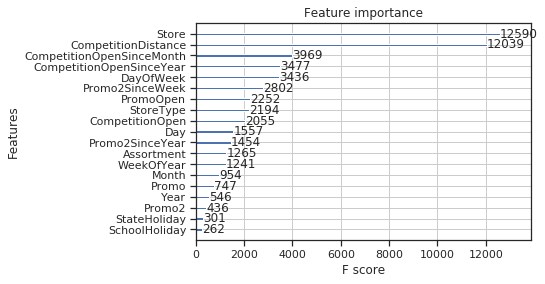

In [60]:
xgb.plot_importance(model_final)

Variables `Store` and `CompetitionDistance` are both leading. Then go features `CompetitionOpenSinceMonth`,  `CompetitionOpenSinceYear`, `DayOfWeek`, `PromoSinceWeek` and deducted features `PromoOpen`.

### Prediction to unseen data

In [61]:
# predictions to unseen data
unseen = xgb.DMatrix(test_store[predictors])
test_p = model_final.predict(unseen)

forecasts = pd.DataFrame({'Id': test['Id'], 
                          'Sales': np.exp(test_p)})
# forecasts
forecasts.head()

,Id,Sales
Date,,
2015-09-17,1,4428.245117
2015-09-17,2,4577.312500
2015-09-17,3,4895.477051
2015-09-17,4,5571.978516
2015-09-17,5,4961.963379


---

## Final thoughts

Time Series Analysis is a must for time series data. It goes much deeper than ad-hoc Exploratory Data Analysis, revealing trends, non randomness of the data and seasonalities. 

I was particularly excited to use a new forecasting procedure `Prophet`. Eventhough this tool is still under development, it has everything set for the advanced modeling as it can account for change points in trends and holidays in the data. In the meantime, the most sophisticated tool for the Time Series Analysis stays `auto.arima` from R `forecast` package. 

A significant jump in the forecasting performance of the model fitted above, XGboost with xgboost library, can be achieved by increasing the number and range of hyperparameters. Due to the number of observations (800k) and with a laptop like mine, the "more developped" grid search would take about 2-3 days to fit. So I left this room for the improvement for later notebooks.

Another method that I didn't cover here is a regression model Stacking, which works great for small or medium size data sets. We would basically combine XGboost, RandomForest, NN and SVM for regression. And then stack them together by building the final model.

Concerning the XGboost model, recently Microsoft [open sourced LightGBM](https://github.com/Microsoft/LightGBM/tree/master/examples/python-guide), a potentially better library than XGboost. For the next project, I will try it out.


Thank you for reading!

#### P.S. Submission 

As it is a Kaggle competition, I made two submissions to leaderboard: forecast from the base and tuned model. 

In [62]:
# first
# 0.66419
test_base = xgb_model.predict(unseen)

forecasts_base = pd.DataFrame({'Id': test['Id'], 
                          'Sales': np.exp(test_base)})
forecasts_base.to_csv("xgboost_2_submission.csv", index = False)

In [63]:
# final
# 0.60553
forecasts.to_csv("xgboost_submission.csv", index = False) 

The score with four tuned parameters __improved from 0.66 to 0.60 on the Public Board__ and __from 0.62 to 0.68 on the Provate Board (test set reserved by Kaggle itself)__ . 

These scores are still quite low, but it's a good start for further improvement. 